<a href="https://colab.research.google.com/github/bilalProgTech/btech-nmims/blob/master/NN-DL/Lab-Work/20230922-Lab-7-2-BTech-NNDL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/'
!kaggle datasets download -d shenba/time-series-datasets -f daily-minimum-temperatures-in-me.csv

  0% 0.00/54.5k [00:00<?, ?B/s]
100% 54.5k/54.5k [00:00<00:00, 16.8MB/s]


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [4]:
data = pd.read_csv('/content/daily-minimum-temperatures-in-me.csv', index_col='Date', parse_dates=True)

data.columns = ['Temperature']
data.head()

,Temperature
Date,
1981-01-01,20.7
1981-01-02,17.9
1981-01-03,18.8
1981-01-04,14.6
1981-01-05,15.8


In [5]:
data.tail()

,Temperature
Date,
1990-12-27,14
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13


In [6]:
data.shape

(3650, 1)

In [8]:
data['Temperature'] = data['Temperature'].str.replace('?', '', regex=True)
data = data.astype('float64')

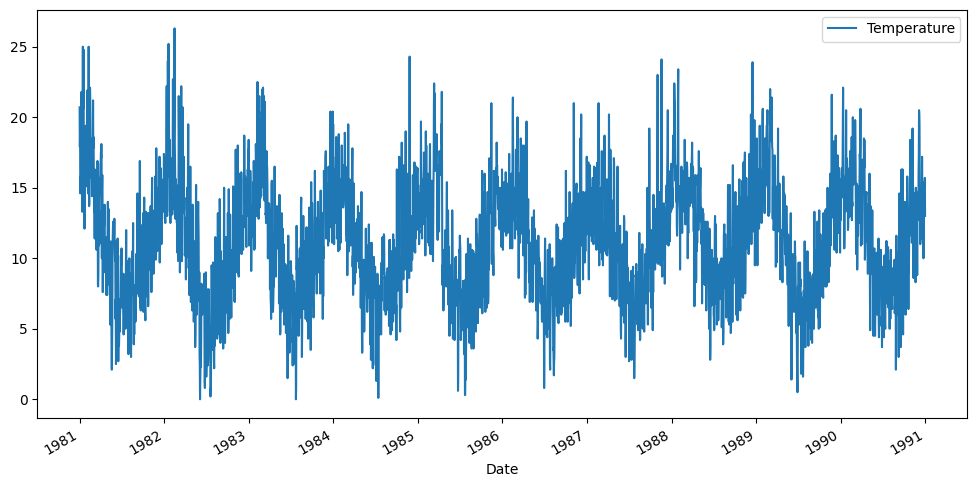

In [9]:
data.plot(figsize=(12,6))
plt.show()

In [10]:
train = data[:'1989-12-31']
test = data['1990-01-01':]
train.shape, test.shape

((3285, 1), (365, 1))

In [11]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequences.append(data[i:i+sequence_length])
    return np.array(sequences)

sequence_length = 90

x_train = create_sequences(train.values, sequence_length)
x_test = create_sequences(test.values, sequence_length)

y_train = train.values[sequence_length:]
y_test = test.values[sequence_length:]

In [12]:
x_train = x_train.reshape((-1, sequence_length, 1))
x_test = x_test.reshape((-1, sequence_length, 1))

In [20]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(sequence_length, 1)),
    tf.keras.layers.Conv1D(filters=128, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
    tf.keras.layers.LSTM(32, activation='relu'),
    tf.keras.layers.Dense(1)
])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 86, 128)           768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 43, 128)          0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 43, 64)            49408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 62,625
Trainable params: 62,625
Non-trainable params: 0
____________________________________________________

In [21]:
model.fit(x_train, y_train, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
100/100 [==============================] - 13s 80ms/step - loss: 4278.8306
Epoch 2/100
100/100 [==============================] - 7s 74ms/step - loss: 9.9904
Epoch 3/100
100/100 [==============================] - 8s 82ms/step - loss: 8.1637
Epoch 4/100
100/100 [==============================] - 6s 62ms/step - loss: 7.5030
Epoch 5/100
100/100 [==============================] - 9s 93ms/step - loss: 7.1298
Epoch 6/100
100/100 [==============================] - 6s 62ms/step - loss: 6.9264
Epoch 7/100
100/100 [==============================] - 11s 107ms/step - loss: 6.9057
Epoch 8/100
100/100 [==============================] - 6s 61ms/step - loss: 6.6288
Epoch 9/100
100/100 [==============================] - 9s 86ms/step - loss: 6.4999
Epoch 10/100
100/100 [==============================] - 7s 69ms/step - loss: 6.4498
Epoch 11/100
100/100 [==============================] - 7s 71ms/step - loss: 6.4783
Epoch 12/100
100/100 [==============================] - 8s 83ms/step - loss: 6.

In [22]:
y_pred = model.predict(x_test)

9/9 [==============================] - 0s 17ms/step


In [23]:
np.sqrt(np.mean((y_test - y_pred)**2))

2.3510745220644904

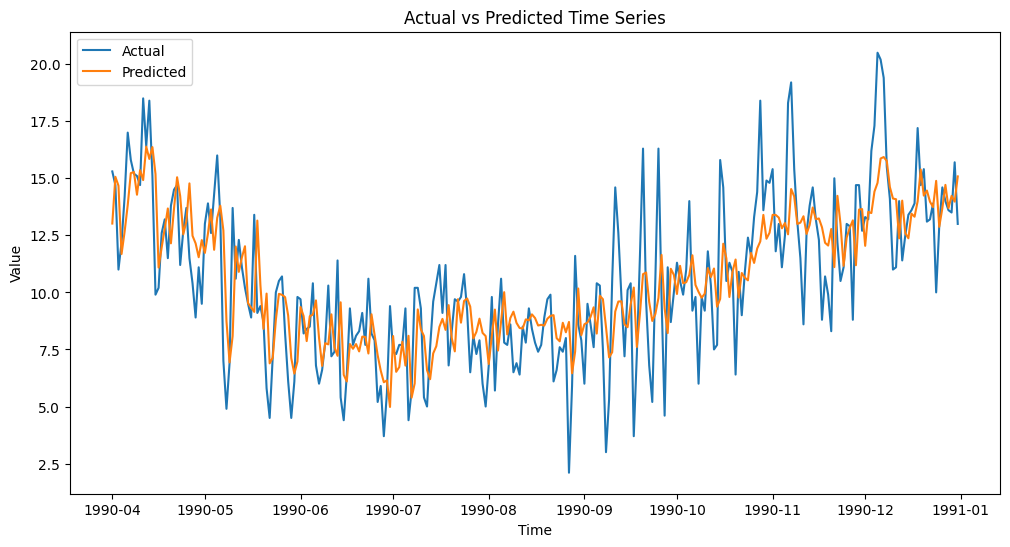

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(test.index[sequence_length:], y_test, label='Actual')
plt.plot(test.index[sequence_length:], y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Time Series')
plt.legend()
plt.show()